**0.   Описание задачи**

По данным о клиенте (возраст, пол, уровень образования, семейное положение, кредитный лимит, история платежей, длительность задолженностей и сумма выплат) необходимо определить, допустит ли он дефолт в следующем месяце (т.е. не произведёт платёж вовремя). Это задача бинарной классификации:

Класс 0: клиент оплатит вовремя

Класс 1: клиент не оплатит (дефолт)

Количество записей в датасете 30 000, количество признаков - 23, количество классов - 2


*Замечу, что я изменил датасет в таблице 17.10.2025. Выбранный ранее датасет соответствовал требованиям курса, но имел ошибки в представлении данных - отсутствие разделяющих символов и неправильное представление текстовых признаков. Считывающихся нормально данных не хватало на тестовую выборку*



In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn



**1.   Чтение данных**

Чтение производится из репозитория на GitHub


In [232]:
url = 'https://raw.githubusercontent.com/ARBUZNIJ/ML_2025/refs/heads/master/UCI_Credit_Card.csv'
data_raw = pd.read_csv(url)

Далее демонстрируются 15 наудачу выбранных строк датасета

In [233]:
#data_raw
data_raw.sample(15)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
12695,12696,20000.0,2,3,2,38,-1,-1,2,0,...,3668.0,3508.0,5278.0,5015.0,0.0,0.0,3508.0,5278.0,780.0,0
17380,17381,630000.0,2,1,1,31,0,0,0,0,...,480587.0,385587.0,373910.0,20000.0,20000.0,20000.0,15000.0,15000.0,15000.0,0
8049,8050,240000.0,1,2,1,39,-1,-1,-1,-1,...,3403.0,2223.0,1761.0,4437.0,11237.0,4293.0,2229.0,1766.0,591.0,0
11405,11406,400000.0,1,2,1,37,-1,-1,-1,-1,...,8585.0,12633.0,20338.0,10000.0,8501.0,9003.0,13000.0,20500.0,11000.0,0
6675,6676,240000.0,2,2,1,32,1,-2,-1,-1,...,-5.0,574.0,3509.0,0.0,493.0,0.0,579.0,3509.0,1198.0,0
20291,20292,360000.0,2,1,1,52,-2,-2,-2,-2,...,6730.0,3595.0,2915.0,2610.0,1240.0,6763.0,3613.0,2930.0,47183.0,0
28906,28907,140000.0,2,1,1,40,1,-1,-1,-1,...,584.0,0.0,190.0,1220.0,0.0,584.0,0.0,190.0,0.0,0
24264,24265,30000.0,1,2,2,25,-2,-2,-2,-2,...,390.0,390.0,390.0,836.0,836.0,390.0,390.0,390.0,0.0,0
24351,24352,190000.0,1,2,1,33,0,0,0,0,...,17907.0,-93.0,-483.0,5000.0,5361.0,1000.0,0.0,0.0,0.0,1
22988,22989,500000.0,2,1,2,42,0,0,0,0,...,159518.0,186563.0,168083.0,20000.0,50000.0,10000.0,50000.0,20000.0,50000.0,0




**2.   Разбиваем данные на обучающую и тестовую выборки**

Определяем столбец с целевой переменной, разбиваем
на обучающую (80%) и тестовую(20%) выборки

In [234]:
target_col = 'default.payment.next.month'

X = data_raw.drop(columns=[target_col])
y = data_raw[target_col]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:",X_test.shape)
print(f"Распределение классов в обучающей выборке:\n{y_train.value_counts(normalize=True)}")

Размер обучающей выборки: (24000, 24)
Размер тестовой выборки: (6000, 24)
Распределение классов в обучающей выборке:
default.payment.next.month
0    0.778792
1    0.221208
Name: proportion, dtype: float64




**3.   Выведем основную статистику числовых признаков**

Следует отметить, что пол (SEX), образование (EDUCATION), семейное положение (MARRIAGE) - категориальные признаки, хоть и выражены численными значениями. Это будет учтено далее.

Признак PAY_i содержит значение -k, если выплата в этом месяце была произведена за k месяцев задолженности, значение n, если задержка выплаты составляет n месяцев. k,n - натуральные.


In [235]:
print(data_raw.describe())

                 ID       LIMIT_BAL           SEX     EDUCATION      MARRIAGE  \
count  30000.000000    30000.000000  30000.000000  30000.000000  30000.000000   
mean   15000.500000   167484.322667      1.603733      1.853133      1.551867   
std     8660.398374   129747.661567      0.489129      0.790349      0.521970   
min        1.000000    10000.000000      1.000000      0.000000      0.000000   
25%     7500.750000    50000.000000      1.000000      1.000000      1.000000   
50%    15000.500000   140000.000000      2.000000      2.000000      2.000000   
75%    22500.250000   240000.000000      2.000000      2.000000      2.000000   
max    30000.000000  1000000.000000      2.000000      6.000000      3.000000   

                AGE         PAY_0         PAY_2         PAY_3         PAY_4  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      35.485500     -0.016700     -0.133767     -0.166200     -0.220667   
std        9.217904      1.123802

Визуализация распределения классов

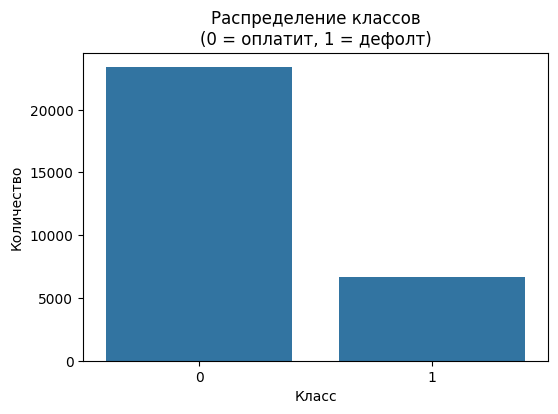

Доля классов:
0 (оплатит): 77.88%
1 (дефолт): 22.12%


In [236]:
plt.figure(figsize=(6, 4))
sns.countplot(x=target_col, data=data_raw)
plt.title('Распределение классов\n(0 = оплатит, 1 = дефолт)')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.show()

class_ratio = data_raw[target_col].value_counts(normalize=True)
print(f"Доля классов:\n0 (оплатит): {class_ratio[0]:.2%}\n1 (дефолт): {class_ratio[1]:.2%}")

**Построение корелляционной матрицы признаков и нахождение наиболее кореллирующих признаков**



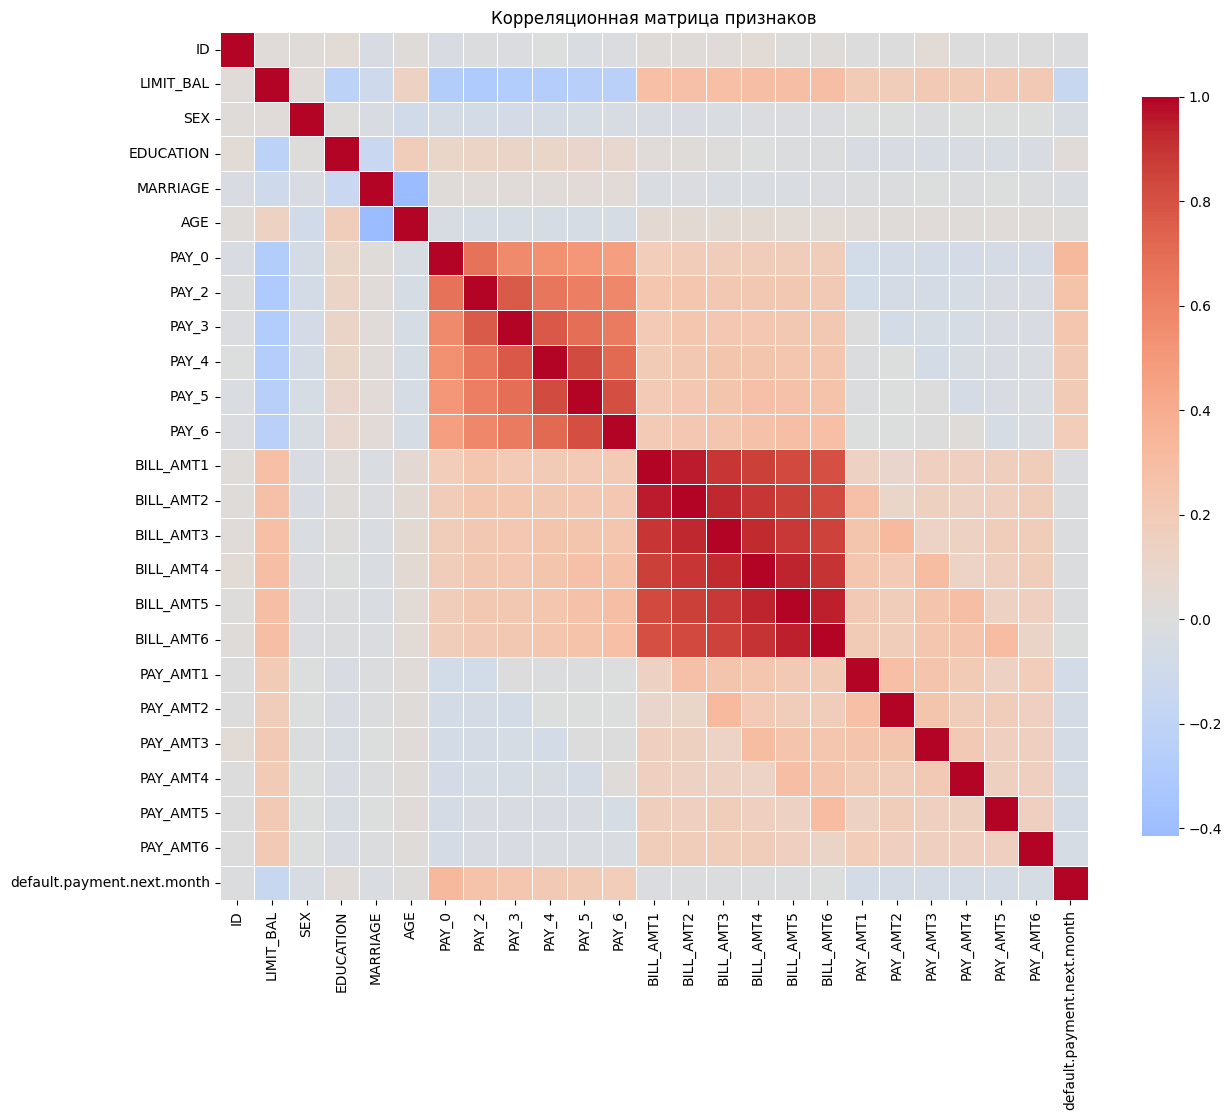


Топ-5 признаков по корреляции с целевой переменной:
PAY_0    0.324794
PAY_2    0.263551
PAY_3    0.235253
PAY_4    0.216614
PAY_5    0.204149
Name: default.payment.next.month, dtype: float64


In [237]:
corr_matrix = data_raw.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title('Корреляционная матрица признаков')
plt.show()

target_corr = corr_matrix[target_col].abs().sort_values(ascending=False)
print("\nТоп-5 признаков по корреляции с целевой переменной:")
print(target_corr[1:6])

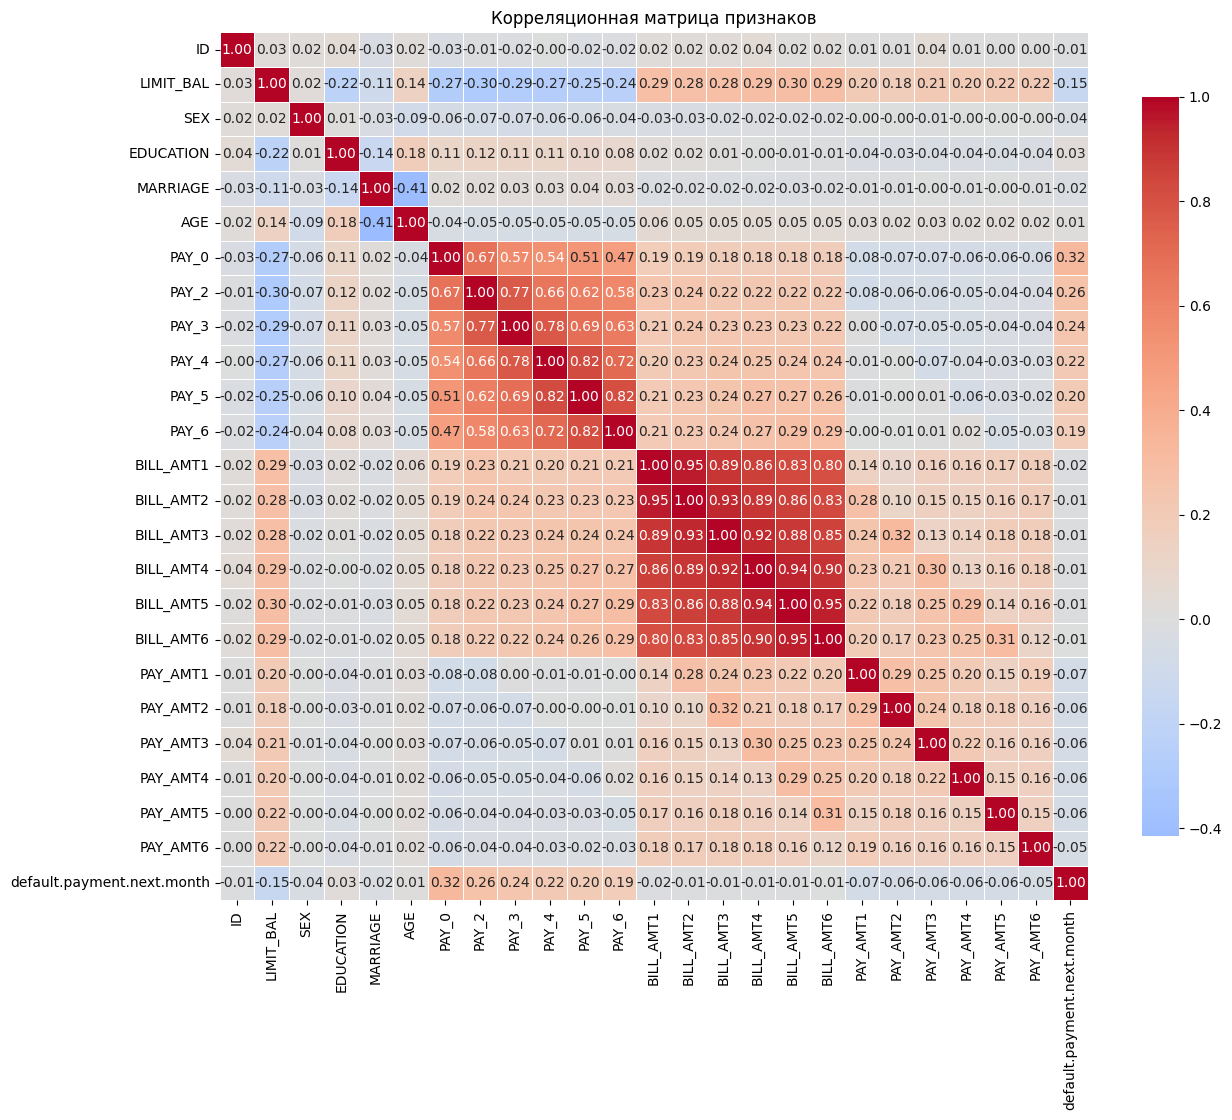

In [238]:
corr_matrix = data_raw.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title('Корреляционная матрица признаков')
plt.show()

Больше всего с целевой переменной кореллирует информация о своевременности выплат. Причём именно выплата в первый (нулевой) месяц кореллирует более заметно. Неужели здесь "встречают по одёжке"??? Спорный вопрос. Значение на пересечении соответстующих строки и столбца сравнительно мало.

Отметим ещё один интересный нюанс: размеры выплат сильно кореллируют друг с другом. Особенно это заметно для выплат в подряд идущие месяцы. Следовательно, в среднем человек, обладающий стабильным доходом (исправно платящий по счетам), тратит схожие суммы каждый месяц. Трудно провести дальнейший анализ в условиях отсутствия данных об условии кредитования



**4. Обращение с пропущенными значениями**



In [239]:
missing = data_raw.isnull().sum()
if missing.sum() == 0:
    print("Пропущенных значений нет.")
else:
    print("Найдено", missing.sum(), "пропущенных значений")

Пропущенных значений нет.


В датасете нет пропущенных значений (банковское дело любит точность...)



**5.   Обработка категориальных признаков**

В описании к датасету уточняется, что некоторые различные значения категориальных признаков следует принять равными. В частности это относится к признакам семейного положения и образования. Обработку их начнём с исследования на наличие этих фиктивно-различных признаков:

In [240]:
values_of_interest = [4, 5, 6]
counts = data_raw['EDUCATION'].value_counts().reindex(values_of_interest, fill_value=0)
print (counts)

EDUCATION
4    123
5    280
6     51
Name: count, dtype: int64


Затем объединим их:

In [241]:
def fix_categories(df):
    df = df.copy()
    df['EDUCATION'] = df['EDUCATION'].replace([0, 5, 6], 4)
    df['MARRIAGE'] = df['MARRIAGE'].replace(0, 3)
    return df

X_train = fix_categories(X_train)
X_test = fix_categories(X_test)



**6.   Проведём нормализацию**

Нормализация обязательна для kNN, так как признаки в разных масштабах:

LIMIT_BAL: от 10 000 до 1 000 000

AGE: 21–79

PAY_0: -2 до 8

Выбран RobustScaler, т.к. StandardScaler сдвигает среднее (центрирует относительно 0), изменяет масштаб. MinMaxScaler же прижимает основную часть данных к одному из краёв отрезка [0, 1]. Оба преобразования не подходят (признаки в датасете смещены вправо). RobustScaler, использующий в преобразовании медиану и межкваркильный размах, устойчив к выбросам и наиболее подходит для этой задачи


In [242]:
scaler = sklearn.preprocessing.RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



**7.   Запуск классификатора (метод k ближайших соседей)**

На начальном этапе выберем k произвольным (k=5)






In [243]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=21, n_jobs=-1)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=21)

Получение предсказаний модели на обучающей и тестовой выборках

In [244]:
y_train_pred = knn.predict(X_train_scaled)
y_test_pred = knn.predict(X_test_scaled)



**8.   Подсчёт ошибок**


С помощью средств библиотеки sklearn.metrics выведем метрики:

Accuracy — доля правильных предсказаний среди всех объектов.

Precision — доля верно предсказанных положительных классов среди всех, кого модель назвала «положительными».

Recall — доля найденных положительных объектов среди всех реальных «положительных».

F1-score — гармоническое среднее между precision и recall.

Выведем также матрицы рассогласования





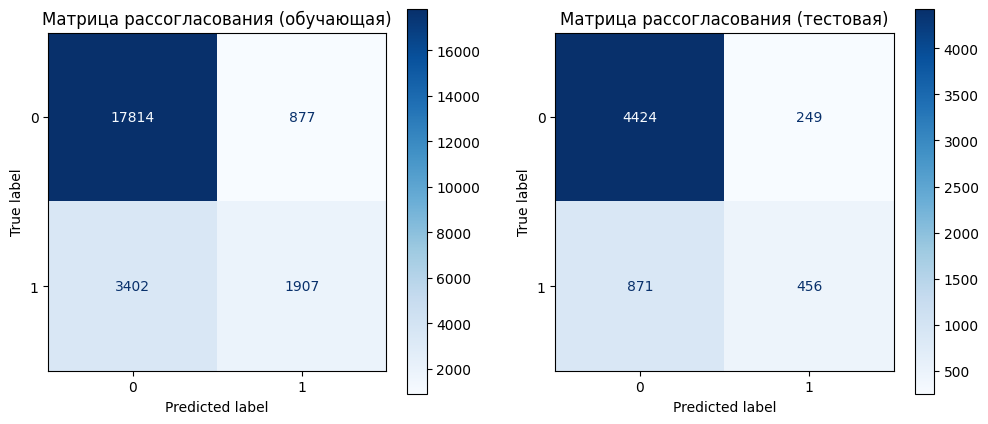


=== Обучающая выборка ===
Accuracy : 0.8217
Precision: 0.6850
Recall   : 0.3592
F1-score : 0.4713

=== Тестовая выборка ===
Accuracy : 0.8133
Precision: 0.6468
Recall   : 0.3436
F1-score : 0.4488


In [245]:
def print_metrics(y_true, y_pred, label):
    acc = sklearn.metrics.accuracy_score(y_true, y_pred)
    prec = sklearn.metrics.precision_score(y_true, y_pred)
    rec = sklearn.metrics.recall_score(y_true, y_pred)
    f1 = sklearn.metrics.f1_score(y_true, y_pred)
    print(f"\n=== {label} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=ax[0], cmap='Blues')
ax[0].set_title('Матрица рассогласования (обучающая)')

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=ax[1], cmap='Blues')
ax[1].set_title('Матрица рассогласования (тестовая)')

plt.show()

print_metrics(y_train, y_train_pred, "Обучающая выборка")
print_metrics(y_test, y_test_pred, "Тестовая выборка")

На первый взгляд может показаться, что результат замечательный - точность около 81% на тестовой выборке - хороший результат. Но правильно ли использовать эту метрику в задачах с несбаллансированными классами?

В датасете:

~78% клиентов не допускают дефолта (класс 0)

~22% клиентов допускают дефолт (класс 1)
Теперь представьте, которая всегда предсказывает 0:

Она будет права в 78% случаев → accuracy = 0.78
Но при этом ни один дефолт не будет обнаружен → recall = 0, F1 = 0

А значение F1-score весьма скромно - не дотягивает до 45%. Попробуем улучшить модель выбором оптимального значения гиперпараметра k (кол-во ближайших соседей).

Далее показана процедура подбора оптимального k на отрезке [3, 35] по нечётным значениям.


=== Финальная модель (оптимальное k = 33 ) ===

=== Обучающая выборка (лучшая модель) ===
Accuracy : 0.8217
Precision: 0.6850
Recall   : 0.3592
F1-score : 0.4713

=== Тестовая выборка (лучшая модель) ===
Accuracy : 0.8133
Precision: 0.6468
Recall   : 0.3436
F1-score : 0.4488


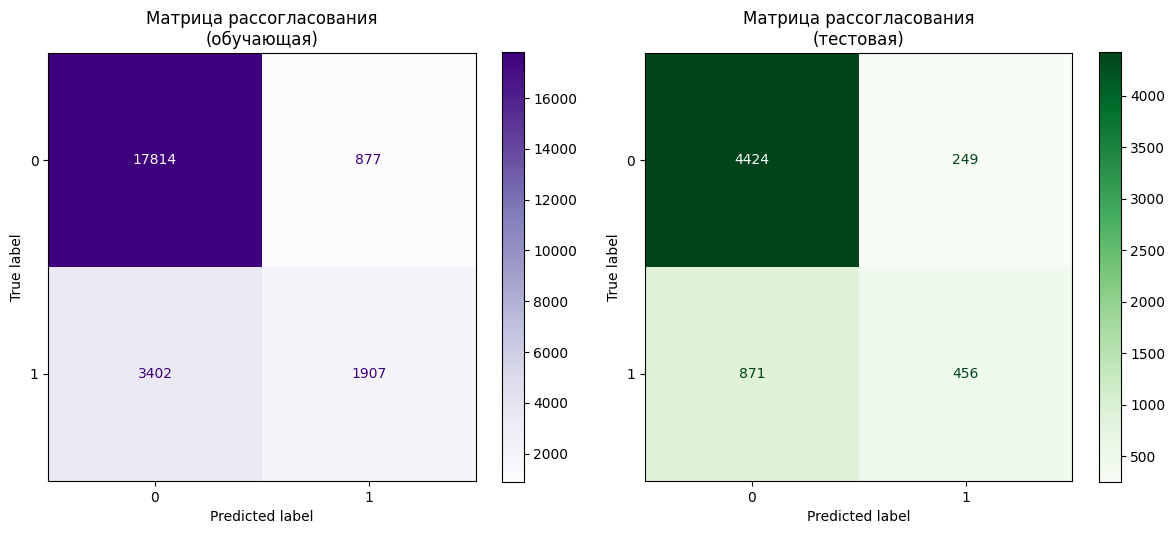

In [246]:
param_grid = {'n_neighbors': list(range(3, 35, 2))}

knn_grid = sklearn.neighbors.KNeighborsClassifier(n_jobs=-1)
grid_search = sklearn.model_selection.GridSearchCV(
    knn_grid,
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
#grid_search = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

y_train_pred_best = best_knn.predict(X_train_scaled)
y_test_pred_best = best_knn.predict(X_test_scaled)

print("\n=== Финальная модель (оптимальное k =", grid_search.best_params_['n_neighbors'], ") ===")
print_metrics(y_train, y_train_pred_best, "Обучающая выборка (лучшая модель)")
print_metrics(y_test, y_test_pred_best, "Тестовая выборка (лучшая модель)")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_best, ax=ax[0], cmap='Purples')
ax[0].set_title('Матрица рассогласования\n(обучающая)')

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_best, ax=ax[1], cmap='Greens')
ax[1].set_title('Матрица рассогласования\n(тестовая)')

plt.tight_layout()
plt.show()

На обучающей выборке модель часто ошибается в сторону класса 0:
FN = 3403 — пропускает 3403 реальных дефолтов → это главная проблема! Модель ложно помечает как дефолтных 873 "хороших" клиента, находит только 36% всех дефолтов, а из тех, кого модель назвала "дефолтными", 68.6% действительно дефолтные.

На тестовой выборке ситуация качественно схожа с ситуацией на обучающей

Такой большой отрезок для поиска k выбран для иллюстрации проблемы: оптимальный k не улучшил F1-score на тестовой выборке даже на процент! Дальнейшее увеличение k бессмысленно - модель начинает игнорировать локальные паттерны и теряет чувствительность к редкому классу (дефолтам).

За кадром остались попытки улучшить точность посредством выбора 5-7 наиболее важных признаков, исключение экстремумов BILL_AMT и PAY_AMT с помощью лог-трансформации. Это не дало больших результатов. Вместо этого приведём пример использования алгоритма Random Forest:

In [247]:
import pandas as pd
import sklearn.model_selection
import sklearn.ensemble
from sklearn.metrics import f1_score, classification_report

url = 'https://raw.githubusercontent.com/ARBUZNIJ/ML_2025/refs/heads/master/UCI_Credit_Card.csv'

df = pd.read_csv(url)

df = df.rename(columns={'default.payment.next.month': 'target'})
df = df.drop('ID', axis=1)




Обработка PAY: создадим признак "была просрочка?", исправим EDUCATION и MARRIAGE, не будем использовать масштабирование. Метрики построим аналогично примерам выше


=== Random Forest ===

=== Обучающая выборка ===
Accuracy : 0.7965
Precision: 0.5331
Recall   : 0.6461
F1-score : 0.5842

=== Тестовая выборка ===
Accuracy : 0.7752
Precision: 0.4931
Recall   : 0.5901
F1-score : 0.5372


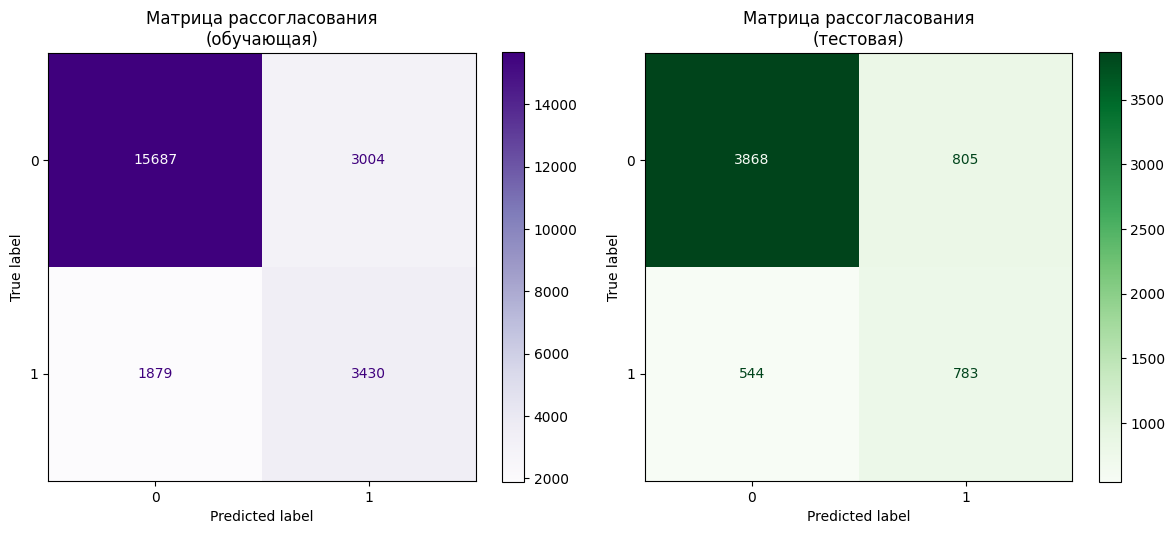

In [248]:
pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
pay_cols = [col for col in pay_cols if col in df.columns]

for col in pay_cols:
    df[f'{col}_late'] = (df[col] > 0).astype(int)

df = df.drop(pay_cols, axis=1)

df['EDUCATION'] = df['EDUCATION'].replace([0, 5, 6], 4)
df['MARRIAGE'] = df['MARRIAGE'].replace(0, 3)

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf = sklearn.ensemble.RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print(f"\n=== Random Forest ===")

print_metrics(y_train, y_train_pred, "Обучающая выборка")
print_metrics(y_test, y_test_pred, "Тестовая выборка")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=ax[0], cmap='Purples')
ax[0].set_title('Матрица рассогласования\n(обучающая)')

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=ax[1], cmap='Greens')
ax[1].set_title('Матрица рассогласования\n(тестовая)')

plt.tight_layout()
plt.show()




**12.   Выводы**



По выбранному датасету были обучены модели с использованием алгоритма kNN и Random Forest. Модель, обученная с использованием Random Forest демонстрирует более высокие показатели метрики F1-score. Действительно, этот алгоритм более приспособлен к наличию выбросов и не требует масштабирования данных. Random Forest находит чуть больше всех дефолтов, чем kNN, но при этом меньше предсказанных дефолтов оказываются реальными. Random Forest чуть более безопасен для использования в финансовой сфере (не так страшен неверно предсказанный дефолт клиента, как не предсказанный). Стоит отметить, что корелляционная матрица содержит невысокие значения корелляций параметров. Это негативно отражается на предсказаниях. Следует попробовать уточнить датасет параметрами, полученными на основе уже существующих или иными, не рассмотренными ранее.